<a href="https://colab.research.google.com/github/CalculatedContent/WeightWatcher-Examples/blob/main/WW_DoubleDesecent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Double Descent: The Original Physics

In this notebook, I attempt to reproduce the results of the 1989 paper

https://iopscience.iop.org/article/10.1209/0295-5075/9/4/003

which first detected the now-so-called Double Descent phenomena.

and show how to detect this phenomena using the HTSR theory behind weightwatcher


### The Model

The idea is to train a linear regression model on a binary classification problem.  (Here, they picked a problem where the generalization error could be computed 'theoreticaly' in the large-N limit.)

The dataset is a sample of  2^{N} hypercube, labeled used what they call the Majority Decision Principle (MDP).  

- pick $P=\alpha N$ patterns from the dataset
- in the paper, they pick $\alpha=[0.5|1.0|1.5$], giving $N=[50|100|150]$
- label data instances (sum of bits is odd or even)
- run linear regression to predict the binary labels
- repeat 100 times
- compute training and test accuracies


#### More Details
We form a dataset consisting of vertices on the n-dimensional hypercube

The label = np.sum(x) is even (1)  or odd (-1)

<pre> i.e for N = 3

Y      X
-1 	 [0 0 0]
-1 	 [0 0 1]
-1 	 [0 1 0]
-1 	 [1 0 0]

 1 	 [0 1 1]
 1 	 [1 0 1]
 1 	 [1 1 0]
 1 	 [1 1 1]
</pre>

We need N=100, so we need to create a random sample directly:


In [1]:
import numpy as np

alpha = 1.0
N =100
P = int(alpha*N)
X = np.random.choice([-1, 1], size=(P, N))
X

array([[-1, -1, -1, ..., -1, -1, -1],
       [ 1,  1,  1, ..., -1,  1, -1],
       [ 1, -1,  1, ...,  1, -1, -1],
       ...,
       [-1,  1,  1, ..., -1,  1, -1],
       [ 1, -1, -1, ..., -1,  1, -1],
       [ 1, -1, -1, ..., -1,  1,  1]])

The label (Y) is just +1 or -1, depending on if the sum of the positive terms is odd or even.

Here's the code that assigns the labels:







In [2]:
import numpy as np

def generate_majority_labels(data):
    """
    Generates labels for each data point based on the majority of its features.
    If the number of positive features is greater than or equal to the number of negative features,
    the label is +1, otherwise, it's -1.

    :param data: NumPy array of data points, where each row is a data point and each column represents a feature.
    :return: Array of labels.
    """
    # Count the number of positive features in each data point
    # Since data points are from a hypercube, features are either -1 or +1
    positive_counts = np.sum(data > 0, axis=1)
    # Total number of features
    total_features = data.shape[1]
    # If the count of positive features is greater than or equal to half of total features, label is +1; otherwise, -1
    labels = np.where(positive_counts >= total_features / 2, 1, -1)
    return labels

# Example usage
N = 10  # Dimensions of the hypercube
num_samples = 10  # Number of samples
# Generate random samples from the hypercube
samples = np.random.choice([-1, 1], size=(num_samples, N))
# Generate majority labels
majority_labels = generate_majority_labels(samples)
majority_labels

array([-1,  1, -1,  1,  1, -1,  1, -1,  1,  1])

Here's a random sample of labeled data (X,Y)  for N=100

We can check if the labels are balanced 50/50 by taking the sum of the labels Y

The data may not be perfectly balanced; that's ok

In [3]:
def generate_mdp_dataset_numpy(P, N):
    X = np.random.choice([-1, 1], size=(P, N))
    Y = generate_majority_labels(X)
    return X, Y


Nalpha = 1.0
N =100
P = int(alpha*N)

X, Y = generate_mdp_dataset_numpy(P,N)
print("Features Matrix:", X.shape)
print("\nLabels Array:", len(Y), np.sum(Y))

print(f"How balanced is the dataset ?  np.sum(Y) = {np.sum(Y)}")


Features Matrix: (100, 100)

Labels Array: 100 0
How balanced is the dataset ?  np.sum(Y) = 0


#### Here is an example of running Logisitic Regression, which gives us the baseline / ideal test accuracy


In [4]:
import numpy as np
# IMPORTS WE NEED FOR NOW AND LATER
from sklearn.linear_model import LogisticRegression,  LinearRegression, Ridge
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


alpha = 1.5
N = 100
P = int(alpha*N)

X, Y = generate_mdp_dataset_numpy(P,N)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Train the logistic regression model (assuming Y_train contains discrete class labels)
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)

# Predict Y values for both the training and test sets
Y_train_pred = classifier.predict(X_train)
Y_test_pred = classifier.predict(X_test)

# Predict labels for both training and test sets
Y_train_pred = classifier.predict(X_train)
Y_test_pred = classifier.predict(X_test)

# Compute accuracy for both training and test sets
train_accuracy = accuracy_score(Y_train, Y_train_pred)
test_accuracy = accuracy_score(Y_test, Y_test_pred)

print(f"train_accuracy {train_accuracy:0.2f}")
print(f"test_accuracy {test_accuracy:0.2f}")

train_accuracy 1.00
test_accuracy 0.67


### Basic Double Descent Curve


Here is code we can use to generate a basic double descent curve

We  create a sample data set, run Linear Regression

In [5]:

def run_LR_experiment(alpha=1.0, verbose=True, N=100):

  P = int(alpha * N)

  X_train, Y_train = generate_mdp_dataset_numpy(P,N)
  X_test, Y_test = generate_mdp_dataset_numpy(P,N)

  # Train the linear regression model
  regressor =  LinearRegression(fit_intercept=False)
  regressor.fit(X_train, Y_train)

  # Predict Y values for the training and test sets
  Y_train_value = regressor.predict(X_train)
  Y_test_value  =  regressor.predict(X_test)

  # Convert predictions to binary class labels based on the condition
  Y_train_pred = np.where(Y_train_value > 0, 1, -1)  # Converts to 1 if Y > 0 else -1
  Y_test_pred = np.where(Y_test_value > 0, 1, -1)  # Converts to 1 if Y > 0 else -1


  # Compute accuracy for both training and test sets
  train_accuracy = accuracy_score(Y_train, Y_train_pred)
  test_accuracy = accuracy_score(Y_test, Y_test_pred)

  if verbose:

    print(f"Runing LR experiment  alpha={alpha:0.2f}")

    # Output the sum of the training labels and also test labels for verification
    print("Sum of Y_train:", np.sum(Y_train))
    print("Sum of Y_test:", np.sum(Y_test))


    # Generate classification reports for both training and test sets
    report_train = classification_report(Y_train, Y_train_pred)
    report_test = classification_report(Y_test, Y_test_pred)

    # Print out the classification reports
    print(f"N={10} P={P} "+r"$\alpha$"+f"={alpha:0.2f} ")
    print("Training Classification Report:\n", report_train)
    print("Test Classification Report:\n", report_test)
    print("\n---------------------------\n")

  # ---

  svals = np.linalg.svd(X_train, compute_uv=False)
  train_evals = 1.0/(svals**2)

  svals = np.linalg.svd(X_test, compute_uv=False)
  test_evals = 1.0/(svals**2)

  return train_accuracy, test_accuracy, train_evals, test_evals

## 3 Alphas, 100 Runs

First, lets run 100 Regressions for each of the  $\alpha\in[0.5, 1.0, 1.5]$ as in the paper

We can see that the test accuracy for $\alpha=1.0\;(P=N)$ is less than for  $\alpha=0.5;(P<N)$ and for  $\alpha=1.5\;(P>N)$

### Solving Linear Regression with the PseudoInverse

To support analysis later, we will solve the Linear Regression problem  using the PseudoInverse method



Given a data pair $\mathbf{x}, y$, we can write Linear Regression problem as
(where, here, the target variable $y$ is just a binary label $[1|-1]$)

$$\mathbf{w^{T}x}=y=[1|-1]$$


We want to find the weight vector $\mathbf{w}$

Lets write the problem using the entire data matrix $\mathbf{X}$ and the vector of labels $\mathbf{y}$.

We can now write the Linear Regression problem in matrix form as

$$\mathbf{w^{T}X}=\mathbf{y}$$

We can write the solutions in terms of the Moore-Penrose PseudoInverse. First, lets flip things around a little

$$\mathbf{X^{T}}\mathbf{w}=\mathbf{y}$$

Now, multiply by $\mathbf{X}$ on both sides of this relation

$$\mathbf{XX^{T}}\mathbf{w}=\mathbf{X}\mathbf{y}$$

We now invert the data covariance matrix $\mathbf{H}=\mathbf{XX^{T}}$

$$\mathbf{w}=(\mathbf{XX^{T}})^{-1}\mathbf{X}\mathbf{y}$$

We now identify the Moore-Penrose PseudoInverse operator $\mathbf{PI}$

$$\mathbf{PI}:=(\mathbf{XX^{T}})^{-1}\mathbf{X}$$

The optimal weight vector is given by


$$\mathbf{w}=\mathbf{PI}.\mathbf{y}$$

As part of our initial analysis, we will compute the eigenvalues $\lambda_{i}$ of the  covariance matrix $\mathbf{H}=\mathbf{XX^{T}}$, as described in the paper

$$\mathbf{H}\mathbf{v}_{i}=\lambda_{i}\mathbf{v}_{i}$$

as well as the distribution  $\rho(\lambda^{-1})$ of the inverse eigenvalues $\lambda^{-1}$





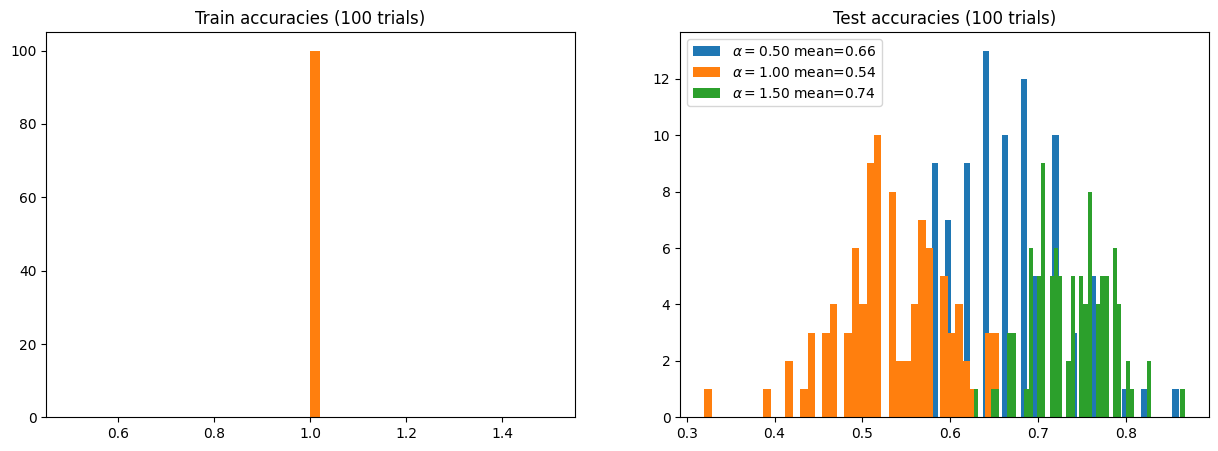

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

train_evals = [[],[],[]]
test_evals = [[],[],[]]

mean_test_accuraces = []
for ia, alpha in enumerate([0.5, 1.0, 1.5]):
  train_accs = []
  test_accs = []

  train_evals[ia] = []
  test_evals[ia] = []

  for idx in range(100):
    a,b, c, d = run_LR_experiment(alpha, verbose=False)
    train_accs.append(a)
    test_accs.append(b)

    train_evals[ia].append(c)
    test_evals[ia].append(d)

  mean_train_acc = np.mean(train_accs)
  mean_test_acc = np.mean(test_accs)

  mean_test_accuraces.append(mean_test_acc)

  axs[0].hist(train_accs, bins=50, label=r"$\alpha=$"+f"{alpha:0.2f} meam={mean_train_acc:0.2f}");
  axs[0].set_title("Train accuracies (100 trials)")

  axs[1].hist(test_accs, bins=50, label=r"$\alpha=$"+f"{alpha:0.2f} mean={mean_test_acc:0.2f}");
  axs[1].set_title("Test accuracies (100 trials)")

plt.legend()



Notice that the  test accuracies have quite a large spread, but, on average, the mean test accuracy for the case $\alpha=1\;(P=N)$ is much smaller than for the other cases.  

Now lets compute the full Double Descent curve

### The full DD curve  is easy to generate

- X-Axis:  The 'load' $\alpha=N/P$, which is a simple measure of model complexity

- Y-Axis:  Test Accuracy

Text(0, 0.5, 'Mean Test Error')

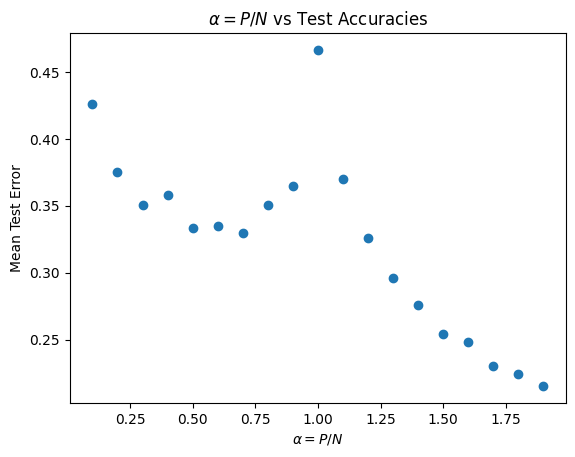

In [7]:
DD_test_accuraces = []
for ia in range(1,20,1):
  train_accs = []
  test_accs = []
  alpha = float(ia/10.0)

  for idx in range(100):
    a,b, c, d = run_LR_experiment(alpha, verbose=False)
    train_accs.append(a)
    test_accs.append(b)

  DD_test_accuraces.append(np.mean(test_accs))

plt.scatter(x=[ia/10.0 for ia in range(1,20,1)], y=1.0-np.array(DD_test_accuraces))
plt.title(r"$\alpha=P/N$ vs Test Accuracies")
plt.xlabel(r"$\alpha=P/N$")
plt.ylabel("Mean Test Error")

# WeightWatcher PowerLaw Analysis

We can use weightwatcher to 'detect' the signatures of overfitting in the extreme case $\alpha=0.5$.  And understand better why this arises.

Recall that we computed and saved the inverse eigenvalues $\lambda^{-1}$ for each of the 100 experimental runs for each $\alpha$.  Here, we combine them, plot the distribution, and (as in weightwatcher), try fit it to a power law distribution to obtain the weightwatcher (WW) $\alpha_{PL}$  

It might be confusing that we have 2 $\alpha$; sorry about that.  To avoid confusion, I will denite the weightwatcher PL layer quality metrix as $\alpha_{PL}$


In [8]:
!pip install powerlaw

### We fit the Inverse ESD to a power law for every experiment, then compute the average PL_alpha

I am not using the weightwatcher GPU-enhanced PL fit, so this may be a bit slow

In [9]:
%%capture
import powerlaw

# save the to re-use in the plots below
PL_alphas = []
std_alphas = []
for ia, load in enumerate([0.5, 1.0, 1.5]):
  print(ia,load)

  PL_fits = []
  for evals in train_evals[ia]:
    fit = powerlaw.Fit(evals)
    alpha_pl = fit.alpha
    PL_fits.append(alpha_pl)

  avg_alpha = np.mean(PL_fits)
  PL_alphas.append(avg_alpha)
  std_alphas.append(np.std(PL_fits))


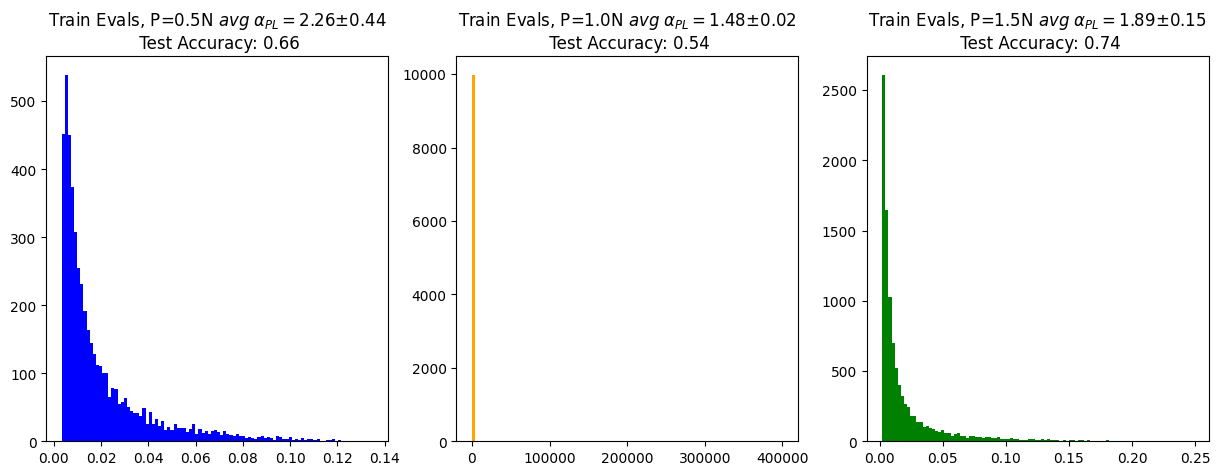

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
colors = ['blue', 'orange', 'green']

for ia, load in enumerate([0.5, 1.0, 1.5]):
  all_evals = []
  for evals in train_evals[ia]:
    all_evals.extend(evals)

  avg_alpha_pl = PL_alphas[ia]
  std_alpha_pl = std_alphas[ia]
  axs[ia].hist(all_evals, bins=100, color=colors[ia])
  title =f"Train Evals, P={load}N"+r" $avg\;\alpha_{PL}=$"+f"{avg_alpha_pl:0.2f}"+r"$\pm$"+f"{std_alpha_pl:0.2f}"
  title +=f"\n Test Accuracy: {mean_test_accuraces[ia]:0.2f}"
  axs[ia].set_title(title)



### Dectecting Double Descent with WeightWatcher

When the model is overfit (due to Double Descent), the weightwatcher poweer law (PL) layer quality metric: $WW\;\alpha_{PL}<<2$  

THis corresponds to the HTSR Very Heavy Tailed (VHT) Univerdsality class



### ESDs on a Log-Log Scale

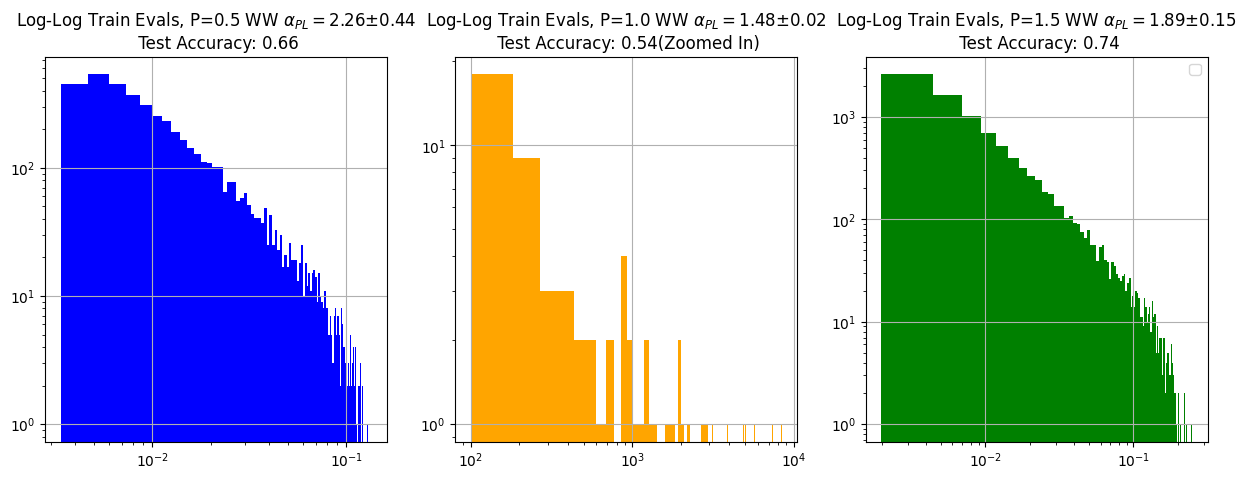

In [11]:
import powerlaw
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
colors = ['blue', 'orange', 'green']

for ia, load in enumerate([0.5, 1.0, 1.5]):
  all_evals = []
  for evals in train_evals[ia]:
    if ia ==1:
      evals = evals[evals<10**4] # easuer to view load=alpha=1.0
      evals = evals[evals>100]
    all_evals.extend(evals)

  axs[ia].hist(all_evals, bins=100, color=colors[ia], log=True)
  avg_alpha_pl = PL_alphas[ia]
  std_alpha_pl = std_alphas[ia]

  title = f"Log-Log Train Evals, P={load}" + r" WW $\alpha_{PL}=$" + f"{avg_alpha_pl:0.2f}"+r"$\pm$"+f"{std_alpha_pl:0.2f}"

  title += f"\n Test Accuracy: {mean_test_accuraces[ia]:0.2f}"
  if ia==1:
    title+="(Zoomed In)"
  axs[ia].set_title(title)
  axs[ia].set_xscale('log')
  axs[ia].set_yscale('log')
  axs[ia].grid(True)

plt.legend()
plt.show()


### It quite amazing that the weight

### ESD of the Data

What does the Empirical Spectral Density (ESD), or eigenvalue distribution,  $\rho(\lambda)$, look like for the original data covariance matrix ?  

These ESDs look similar to (but not exactly like) the associated Marchenko Pastur (MP) disributions for these data matrices

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_marchenko_pastur(Q, ax=None, x_shift=0.0, y_scale=1.0):
    """
    Plots the Marchenko-Pastur distribution for a given aspect ratio Q on the provided axes.
    If no axes are provided, creates a new figure and axes.

    Args:
        Q (float): The aspect ratio of the matrix (number of columns / number of rows).
        ax (matplotlib.axes.Axes, optional): The axes on which to plot the distribution. Defaults to None.
    """
    # Marchenko-Pastur parameters
    a = (1 - np.sqrt(1 / Q))**2
    b = (1 + np.sqrt(1 / Q))**2

    # Marchenko-Pastur probability density function
    def mp_pdf(x, Q):
        return (1 / (2 * np.pi * x * Q)) * np.sqrt((b - x) * (x - a))

    # Define x values for plotting
    x_values = np.linspace(a, b, 1000)

    # Compute the corresponding y values for the MP distribution
    y_values = mp_pdf(x_values, Q)

    # Plotting
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))  # Create new figure and axes if none are provided

    x_values += x_shift
    y_values *= y_scale

    ax.plot(x_values, y_values, label=f'Marchenko-Pastur ($Q={Q:0.2f}$)')
    ax.fill_between(x_values, y_values, color='skyblue', alpha=0.5)
    ax.set_title('Marchenko-Pastur Distribution')
    ax.set_xlabel('Eigenvalue')
    ax.set_ylabel('Probability Density')
    ax.legend()
    ax.grid(True)

#fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with two subplots
#plot_marchenko_pastur(10, ax=axs[0])  # Plot MP distribution on the first subplot

<ipython-input-12-46fcc9d454b2>:19: RuntimeWarning: divide by zero encountered in divide
  return (1 / (2 * np.pi * x * Q)) * np.sqrt((b - x) * (x - a))
<ipython-input-12-46fcc9d454b2>:19: RuntimeWarning: invalid value encountered in multiply
  return (1 / (2 * np.pi * x * Q)) * np.sqrt((b - x) * (x - a))


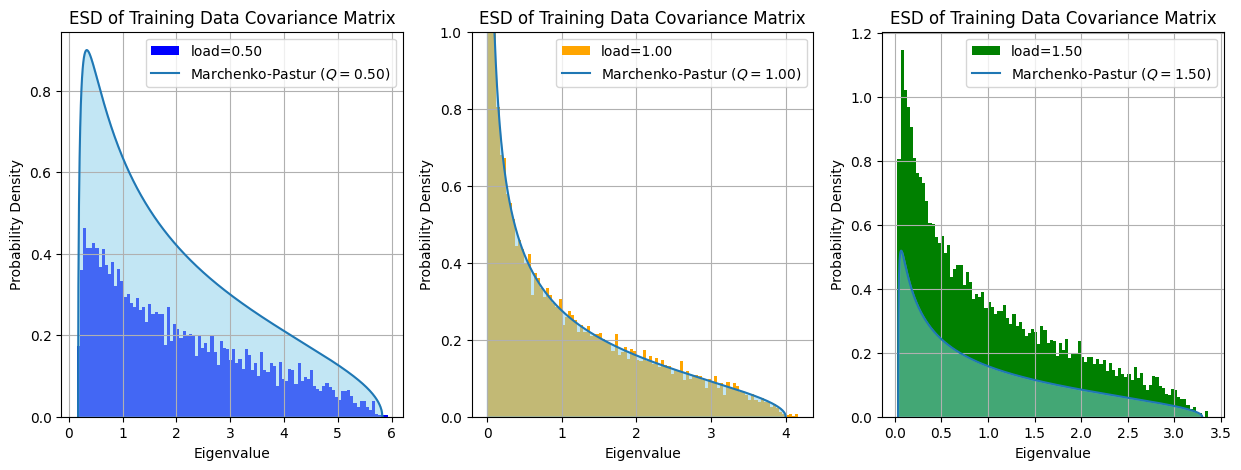

In [13]:

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
colors = ['blue', 'orange', 'green']

for ia, load in enumerate([0.5, 1.0, 1.5]):
  P = load*N
  all_evals = []
  for evals in train_evals[ia]:
    evals = (1/P)*(1.0/np.array(evals)) # inverse evals, rescaled
    all_evals.extend(evals)

  axs[ia].hist(all_evals, bins=100, label=f"load={load:0.2f}", color=colors[ia], density=True)
  plot_marchenko_pastur(Q=load, ax=axs[ia], y_scale=1.0)
  axs[ia].set_title("ESD of Training Data Covariance Matrix")

  if ia==1:
    axs[ia].set_ylim(0,1)


plt.legend()
plt.show()

### Why does load $\alpha=1\;(P=N)$ give the weightwatahcer $\alpha_{PL}<2$ ?

Learning is an inverse problem.

What matters is the statistics of the inverse covarince matrix, not the data covariance matrix itself.

Given a 'random' data matrix (a matrix of i.i.d random data), if it is square, then the ESD $\rho(\lambda)$. of the data covariance matrix resembles (or is exactly) a Marchenko-Pastur  disttribution (middle plot).

Notice that when $P=N$, as here, then the ESD has a large peak at $\lambda=0$.  And only for $P=N$.

Given this, the ESD of the inverse covarince matrix $rho(\lambda^{-1})$ will have a very long, heavy tail.  And when fit to a Power Law (PL), the PL exponent $\alpha_{PL}$ will most likely be less than 2, i.e.the weighwatcher (WW) $\alpha_{PL}<2$



# Analyzing the full DD curve with WeightWatcher

Now we repeat the above experiment to compute the full Double Descent experiment and show that the weightwatcher layer quality metric  $(\alpha)$ can reproduce the DD curve in the OverParmaterized regime when using $\alpha$ as the model capacity metric

Note:  you need weighrwatcher version 0.7.5 or higher for this


In [14]:
!pip install weightwatcher

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 kB 748.4 kB/s eta 0:00:00


In [15]:
import weightwatcher as ww
ww.__version__

'0.7.5.2'

### Create a dummy model to store the weight matrix

In [16]:
import torch
import torch.nn as nn

class SingleLayerModel(nn.Module):
    def __init__(self, weights):
        super(SingleLayerModel, self).__init__()

        # Infer dimensions from weights
        output_dim, input_dim = weights.shape

        # Initialize the linear layer without bias
        self.linear = nn.Linear(in_features=input_dim, out_features=output_dim, bias=False)

        # Set custom weights
        self.linear.weight = nn.Parameter(torch.tensor(weights, dtype=torch.float))

    def forward(self, x):
        # Forward pass through the linear layer
        return self.linear(x)

### Redfine run_LR_experiment to run_WW_experiment

In [17]:
def run_WW_experiment(load_alpha=1.0, verbose=True, N=100, detX=False):

  P = int(load_alpha * N)

  X_train, Y_train = generate_mdp_dataset_numpy(P,N)
  X_test, Y_test = generate_mdp_dataset_numpy(P,N)

  # Train the linear regression model
  regressor =  LinearRegression(fit_intercept=False)
  regressor.fit(X_train, Y_train)

  # Predict Y values for the training and test sets
  Y_train_value = regressor.predict(X_train)
  Y_test_value  =  regressor.predict(X_test)

  # Convert predictions to binary class labels based on the condition
  Y_train_pred = np.where(Y_train_value > 0, 1, -1)  # Converts to 1 if Y > 0 else -1
  Y_test_pred = np.where(Y_test_value > 0, 1, -1)  # Converts to 1 if Y > 0 else -1


  # Compute accuracy for both training and test sets
  train_accuracy = accuracy_score(Y_train, Y_train_pred)
  test_accuracy = accuracy_score(Y_test, Y_test_pred)

  model = SingleLayerModel(weights=X_train)
  watcher = ww.WeightWatcher(model=model)
  # the inverse option was added specifiically for this DD experiment
  # detX option used below
  if detX:
    details = watcher.analyze(inverse=True, detX=True, plot=True)
    return train_accuracy, test_accuracy, details

  else:
    details = watcher.analyze(inverse=True) #

    alpha = details.alpha
    Dks = details.D
    return train_accuracy, test_accuracy, alpha, Dks





###  Rerun the experiment for the Over-Parmaterized and Under-Parmeterized regions

- Over-Parmaterized:  load < 1 (more features than data points)
- Under-Parmeterized:  load > 1

In [18]:
from tqdm.notebook import tqdm

In [ ]:
WW_test_accuraces = []
WW_mean_alphas = []
WW_mean_Dks = []

NUM_IA = 30
for ia in tqdm(range(1,NUM_IA,1)):
  test_accs = []
  WW_alphas = []
  WW_Dks = []

  for idx in range(100):
    load_alpha = ia/10.0
    train_acc, test_acc, alpha, Dks = run_WW_experiment(load_alpha, verbose=False)
    test_accs.append(test_acc)
    WW_alphas.append(alpha)
    WW_Dks.append(Dks)

  WW_test_accuraces.append(np.mean(test_accs))
  WW_mean_alphas.append(np.mean(WW_alphas))
  WW_mean_Dks.append(np.mean(WW_Dks))


alpha_loads = np.array([ia/10.0 for ia in range(1,NUM_IA,1)])
over_p_mask = alpha_loads <= 1.0
under_p_mask = alpha_loads > 1.0


WW_mean_alphas = np.array(WW_mean_alphas)
WW_mean_Dks = np.mean(WW_mean_Dks)
WW_test_errors = 1.0 - np.array(WW_test_accuraces)



  0%|          | 0/29 [00:00<?, ?it/s]

In [ ]:
plt.scatter(x=WW_mean_alphas[over_p_mask], y=WW_test_errors[over_p_mask], label="over-parameterized", color='orange')
plt.scatter(x=WW_mean_alphas[under_p_mask], y=WW_test_errors[under_p_mask], label="under-parameterized", color='blue')

title =  r"Double Descent Experiment: Over- and Under-Parameterized Regiems"
title += "\n"
title += r"WeightWatcher mean layer quality metric $\alpha_{PL}$  vs Mean Test Error"

plt.title(title)
plt.xlabel(r"WeightWatcher (mean) layer quality metric $\alpha_{PL}$")
plt.ylabel("Mean Test Error")
plt.axvline(x=2.0, color='red')
plt.legend()
plt.show()

# DetX condition

The weightwatcher theory predicts that when learning is ideal, the eigenvalues of the layer correlation matrix $\mathbf{X}$ will satisify a Volume Preserving Transformation

https://calculatedcontent.com/2023/02/01/deep-learning-and-effective-correlation-spaces/

Specifically, in the case of Ideal Learning, the theory predicts

- the weightwatcher PL exponent $\alpha_{WW}=2.0$

- the eigenvalues in the PL tail satsify $\sum_{i}\log\lambda_{i}=\log\det \mathbf{X}^{ECS}=0.0$

These conditions can be tested by running (with inverse=True here)
```
details = watcher.analyze(inverse=True, detX=True)
```
and by comparing the 2 columns

- *num_pl_spikes*: number of eigenvalues (or spikes) in the PL tail:  $\lambda_{i}>\lambda^{PL}_{min}$
- *detX_num:* number of 'tail' eigenvalues that satisfy: $\sum_{i}\log\lambda_{i}\approx 0$

Typically, if $\alpha_{PL}>2$, then *detX_num > num_pl_spikes*

We compute the difference between these 2 counts

-  *delta_num_evals := detX_num - num_pl_spikes*

And plot this as a funciton of the Power Law fit $\alpha^{PL}$

### Lets first run 1 experiment, and generate the standard weightwatcher plots

Play attention to the last plot, which shows the eigenvaules on a Log-Linear scale

The red line corresponds to the start of the Power Law (PL) tail

The purple line corresponds to the start of the tail defined by the Volumen Preserving Transformation

Notice that as $\alpha~2.0$, the purple and red lines get closer and closer.

#### If you don't observe this...

Run the random example again...below we will see that the closer $\alpha$ is to $2.0$, the closer the 2 lines become

In [ ]:
train_accuracy, test_accuracy, details =  run_WW_experiment(alpha, verbose=True, N=1000, detX=True)


### Now run the experiment 100 times and plot all results for all random $\alpha_{PL}$ we find

In [ ]:
%%capture
import pandas as pd

all_details = details
for idx in range(100):
    train_accuracy, test_accuracy, details =  run_WW_experiment(alpha, verbose=True, N=1000, detX=True)
    details['idx']=idx
    if all_details is None:
      all_details = details
    else:
      all_details = pd.concat([all_details, details])


Remarkably, when $\alpha_{PL}=2.0$, *delta_num_evals=0* exactly, meaning that the Volume Preserving Transformation is also exact!

In [ ]:
all_details['delta_num_evals']=all_details['detX_num'] - all_details['num_pl_spikes']
all_details.plot.scatter('alpha', 'delta_num_evals')
plt.axvline(x=2.0, color='red')
plt.axhline(y=0.0, color='red')

title = "Double Descent Best Model (P=0.5N)" +"\n" + r"WeightWatcher $\alpha_{PL}$ vs delta_num_evals"
plt.title(title)